In [7]:

import pandas as pd
import numpy as np
import sqlalchemy

import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from data import db


SYMBOL = "ETH"
start = "2023-10"
end = "2024"

DB = db.connect_db("database", interval="1h")
data = DB.get_data(SYMBOL)
data = data.loc[start:end]

# Convert all column names to plain Python strings
data.columns = [str(col) if isinstance(col, sqlalchemy.sql.elements.quoted_name) else col for col in data.columns]
print("Column names and types after conversion:")
for col in data.columns:
    print(f"Column: {col}, Type: {type(col)}")

Column names and types after conversion:
Column: open, Type: <class 'str'>
Column: high, Type: <class 'str'>
Column: low, Type: <class 'str'>
Column: close, Type: <class 'str'>
Column: volume, Type: <class 'str'>


In [8]:

# Préparer les données
close = data['close']
volume = data['volume']


def compute_daily_volatility(price_series, span=24):
    returns = price_series.pct_change()
    volatility = returns.ewm(span=span).std()
    return volatility


volatility = compute_daily_volatility(close)

In [9]:
df = pd.DataFrame(index=data.index)

#df['date'] = data.index.date
df['hour'] = data.index.hour

df['rets'] = data['close'].pct_change()
df['rets_3'] = data['close'].pct_change(3)
df['rets_5'] = data['close'].pct_change(5)
df['rets_7'] = data['close'].pct_change(7)

df['rets2'] = 1 + df['rets']
#df['cum_rets_per_day'] = df.groupby('date')['rets2'].cumprod()-1
#df['log_rets'] = np.log(df['close'] / df['close'].shift(1))


df['sma1'] = data['close'].rolling(6).mean()
df['sma2'] = data['close'].rolling(12).mean()
df['sma3'] = data['close'].rolling(24).mean()
df['sma4'] = data['close'].rolling(3*24).mean()


df['sma1>sma2'] = (df['sma1'] > df['sma2']).astype(int)
df['sma2>sma3'] = (df['sma2'] > df['sma3']).astype(int)
df['sma3>sma4'] = (df['sma3'] > df['sma4']).astype(int)


df['rel_distance_1_2'] = (df['sma1'] - df['sma2']) / df['sma2']
df['rel_distance_2_3'] = (df['sma2'] - df['sma3']) / df['sma3']
df['rel_distance_3_4'] = (df['sma3'] - df['sma4']) / df['sma4']


cols_drop = ['rets2', 'sma1', 'sma2', 'sma3', 'sma4']
df.drop(columns=cols_drop, inplace=True)
print(df.shape)
df.head(5)

(2208, 11)


,hour,rets,rets_3,rets_5,rets_7,sma1>sma2,sma2>sma3,sma3>sma4,rel_distance_1_2,rel_distance_2_3,rel_distance_3_4
time,,,,,,,,,,,
2023-10-01 00:00:00,0,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN
2023-10-01 01:00:00,1,0.000000,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN
2023-10-01 02:00:00,2,-0.000167,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN
2023-10-01 03:00:00,3,0.000454,0.000287,NaN,NaN,0,0,0,NaN,NaN,NaN
2023-10-01 04:00:00,4,0.000615,0.000902,NaN,NaN,0,0,0,NaN,NaN,NaN


In [10]:
pd.DataFrame(df['rel_distance_1_2'].describe())

,rel_distance_1_2
count,2197.000000
mean,0.000428
std,0.004905
min,-0.024330
25%,-0.002157
50%,0.000119
75%,0.002565
max,0.025913


In [11]:
df['rel_distance_2_3'].describe()

count    2185.000000
mean        0.000857
std         0.007043
min        -0.023825
25%        -0.003165
50%         0.000299
75%         0.003809
max         0.034822
Name: rel_distance_2_3, dtype: float64

In [12]:
distance = ['rel_distance_1_2', 'rel_distance_2_3', 'rel_distance_3_4']
df[distance].dropna()

px.line(df[distance].dropna())

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [14]:
from sklearn.metrics import silhouette_score

X = df.dropna()

kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

labels = kmeans.labels_
centers = kmeans.cluster_centers_


c:\Users\Dell\miniconda3\envs\ml\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "c:\Users\Dell\miniconda3\envs\ml\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Dell\miniconda3\envs\ml\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Dell\miniconda3\envs\ml\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Dell\miniconda3\envs\ml\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
c:\Users\Dell\minicon

c:\Users\Dell\miniconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.

c:\Users\Dell\miniconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.

c:\Users\Dell\miniconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.

c:\Users\Dell\miniconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, 

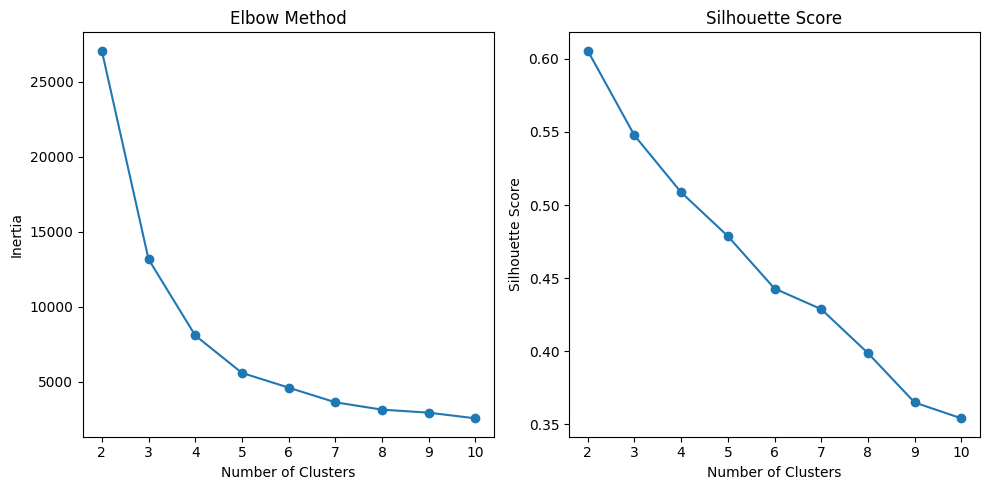

In [15]:

# Evaluate the KMeans model
# Find the optimal number of clusters using the elbow method
inertia = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X, labels))

# Plot the inertia and silhouette scores
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()


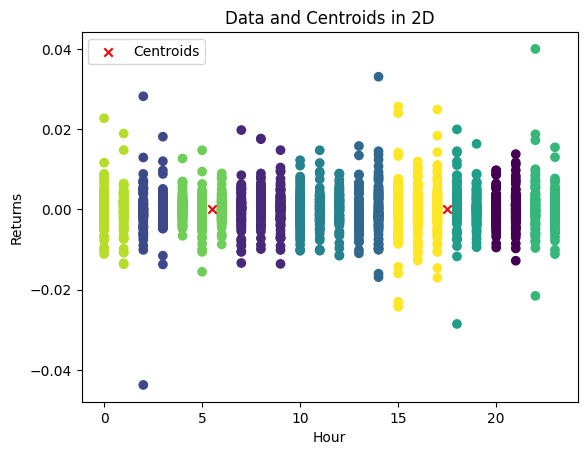

In [16]:
import matplotlib.pyplot as plt

# Extraire les coordonnées des centroïdes
x = centers[:, 0]
y = centers[:, 1]

# Créer un graphique de dispersion pour les données
plt.scatter(X['hour'], X['rets'], c=labels, cmap='viridis')
plt.xlabel('Hour')
plt.ylabel('Returns')
plt.title('Data and Centroids in 2D')

# Ajouter les centroïdes au graphique
plt.scatter(x, y, c='red', marker='x', label='Centroids')
plt.legend()

# Afficher le graphique
plt.show()

In [17]:
X['labels'] = labels
X

C:\Users\Dell\AppData\Local\Temp\ipykernel_5116\2169413176.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,hour,rets,rets_3,rets_5,rets_7,sma1>sma2,sma2>sma3,sma3>sma4,rel_distance_1_2,rel_distance_2_3,rel_distance_3_4,labels
time,,,,,,,,,,,,
2023-10-03 23:00:00,23,-0.000416,0.000115,0.004827,0.003574,1,0,0,0.000222,-0.003069,-0.014305,6
2023-10-04 00:00:00,0,-0.011123,-0.009821,-0.007168,-0.010281,1,0,0,0.000063,-0.003370,-0.014602,8
2023-10-04 01:00:00,1,0.000494,-0.011046,-0.010521,-0.005858,1,0,0,0.000047,-0.003744,-0.015030,8
2023-10-04 02:00:00,2,0.001556,-0.009095,-0.007790,-0.005132,0,0,0,-0.001118,-0.003441,-0.015402,2
2023-10-04 03:00:00,3,0.000024,0.002075,-0.009484,-0.008958,0,0,0,-0.002083,-0.003175,-0.015729,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,19,-0.003630,-0.004066,-0.002426,-0.003461,0,1,0,-0.001065,0.002657,-0.007115,5
2023-12-31 20:00:00,20,-0.005417,-0.006935,-0.007216,-0.008919,0,1,0,-0.001918,0.002499,-0.006986,0
2023-12-31 21:00:00,21,0.000351,-0.008679,-0.009114,-0.007481,0,1,0,-0.002086,0.001851,-0.006946,0


In [18]:
fig = go.Figure()

fig.add_trace(
    go.Candlestick(
        x = data.index , open = data.open, close = data.close,
        high = data.high, low = data.low, name = SYMBOL
    )
)

fig.add_trace(
    go.Scatter(
        x = data['sma1'].index , y = data['sma1'], marker={'color' : 'black'}
    )
)
fig.add_trace(
    go.Scatter(
        x = data['sma2'].index , y = data['sma2'], marker={'color' : 'blue'}
    )
)
fig.add_trace(
    go.Scatter(
        x = data['sma3'].index , y = data['sma3']
    )
)

fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.update_xaxes(rangeslider_visible=False)
fig.update_layout(height = 800 , width =1500,
                  margin=dict(
                        l=5, r=0, b=10, t=30,
                        pad=1
                    ),
                  showlegend=True,
                  )



KeyError: 'sma1'

In [ ]:
#data.iloc[:1000][['close', 'volume']].to_excel("ETH.xlsx")

In [19]:
leverage = 5

events = pd.DataFrame(index=data.index)

events['date'] = data.index.date
events['hour'] = data.index.hour
events['price'] = data['close']

events['rets'] = data['close'].pct_change() * leverage
events['log_rets'] = np.log(data['close'] / data['close'].shift(1)) * leverage

events['cum_rets_per_day'] = events.groupby('date')['log_rets'].cumsum()
events['cum_log_rets'] = np.exp(events['log_rets'].cumsum()) - 1

events["side"] = np.sign(events['rets'])
events['vols'] = volatility

events['tp'] = events['rets'] + events['vols'] * leverage
events['sl'] = events['rets'] - events['vols'] * leverage

events['lev_rets'] = leverage*events['rets']


#events.dropna(inplace=True)
#events['touch_sl'] = np.where(events['lev_rets'] <= events["sl"], 1, 0)
#events['touch_tp'] = np.where(events['lev_rets'] >= events["tp"], 1, 0)

trg_up = 0.01
trg_down = -0.01
events['touch_tp'] = np.where(events['cum_rets_per_day'] >= trg_up, 1, 0)
events['touch_sl'] = np.where(events['cum_rets_per_day'] <= trg_down, 1, 0)

events

,date,hour,price,rets,log_rets,cum_rets_per_day,cum_log_rets,side,vols,tp,sl,lev_rets,touch_tp,touch_sl
time,,,,,,,,,,,,,,
2023-10-01 00:00:00,2023-10-01,0,1674.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2023-10-01 01:00:00,2023-10-01,1,1674.01,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,0.000000,0,0
2023-10-01 02:00:00,2023-10-01,2,1673.73,-0.000836,-0.000836,-0.000836,-0.000836,-1.0,0.000118,-0.000245,-0.001428,-0.004182,0,0
2023-10-01 03:00:00,2023-10-01,3,1674.49,0.002270,0.002270,0.001433,0.001435,1.0,0.000329,0.003916,0.000625,0.011352,0,0
2023-10-01 04:00:00,2023-10-01,4,1675.52,0.003076,0.003075,0.004508,0.004518,1.0,0.000372,0.004938,0.001214,0.015378,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,2023-12-31,19,2294.83,-0.018149,-0.018182,0.006868,3.841304,-1.0,0.002990,-0.003197,-0.033101,-0.090744,0,0
2023-12-31 20:00:00,2023-12-31,20,2282.40,-0.027083,-0.027156,-0.020288,3.711602,-1.0,0.003217,-0.010998,-0.043167,-0.135413,0,1
2023-12-31 21:00:00,2023-12-31,21,2283.20,0.001753,0.001752,-0.018536,3.719865,1.0,0.003096,0.017234,-0.013729,0.008763,0,1


In [20]:
events['cum_rets_per_day'].describe()

count    2207.000000
mean        0.005050
std         0.082011
min        -0.363111
25%        -0.031871
50%         0.002347
75%         0.037729
max         0.582285
Name: cum_rets_per_day, dtype: float64

In [21]:
events['touch_tp'].resample('1d').sum().describe()

count    92.000000
mean     10.326087
std       8.352283
min       0.000000
25%       2.750000
50%       9.000000
75%      18.000000
max      24.000000
Name: touch_tp, dtype: float64

In [22]:
events['touch_sl'].resample('1d').sum().describe()

count    92.000000
mean      9.347826
std       8.246791
min       0.000000
25%       1.000000
50%       8.500000
75%      16.250000
max      24.000000
Name: touch_sl, dtype: float64

In [ ]:
px.line(events[['log_rets', 'cum_log_rets', 'cum_rets_per_day']])

In [ ]:
events['touch_sl'].resample('1d').sum()

In [ ]:
#data['date'] = data.index.date
#data["hour"] = data.index.hour


In [ ]:
data['close'].resample("1d").apply(lambda x : compute_daily_volatility(x))

In [ ]:
e e 

# ----------------------------------------------------------------------